Dit is de EDA voor BE.... bestanden, be52.. bestanden.  
Dit bevat verschillende instel waardes voor de linac bij een bepaalde energie. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
import seaborn as sns



### Overzicht van de data

In [2]:
df_db = pd.read_csv("data/cal_changed.csv", header = None, names=["date", "linac", "file_name", "item", 'part', "value"], )
names_files = list(set(df_db["file_name"]))
df_db.head()

,date,linac,file_name,item,part,value
0,2023-09-13,2325,Be5201,1,4,5201
1,2023-10-04,2325,Be5201,1,4,5201
2,2023-10-11,2325,Be5201,1,4,5201
3,2023-10-18,2325,Be5201,1,4,5201
4,2023-10-25,2325,Be5201,1,4,5201


In [3]:
df_db.shape

(205746, 6)

Deze data bevat de datum van uploaden, nummer van het linac toestel, het bestandsnaam waar de data vandaan komt, item nummer, part nummer en value.  

Het item nummer en part nummer zijn aan elkaar gebonden, en vormen samen een bepaalde instelling op dat apparaat met een bepaalde waarde: value.  

Dit is een deel van de database van maar 1 linac, maar dit bevat al een aardige grootte aan bestanden.  


De bestandsnamen zijn optedelen in 3 categorieën:  

{'Be52', 'Be55', 'Be63'}

{'Mlc_Iso_Centre',  
 'Mlc_Leaf_Sensor_Dir',  
 'Mlc_Leaf_Sensor_Gain',  
 'Mlc_Leaf_Sensor_Off',  
 'Mlc_Leaf_Sensor_Orig',  
 'Mlc_Minr_Off',  
 'Mlc_Sensor_Gains',  
 'Mlc_cal_data',  
 'Mlc_gain_adj',  
 'Mlc_leaf_travel',  
 'Mlc_refl_width'}
  
 {'Optics_Dist_Y1_01_To_40',  
 'Optics_Dist_Y1_41_To_80',  
 'Optics_Dist_Y2_01_To_40',  
 'Optics_Dist_Y2_41_To_80',  
 'Optics_Gen_Cal_Data',  
 'Optics_LP_X_01_To_20',  
 'Optics_LP_X_21_To_40',  
 'Optics_LP_X_41_To_60',  
 'Optics_LP_X_61_To_80',  
 'Optics_LP_Y_01_To_20',  
 'Optics_LP_Y_21_To_40',  
 'Optics_LP_Y_41_To_60',  
 'Optics_LP_Y_61_To_80'}

#### Inzoomen in de data  

Er gaat een focus naar de Be.... bestanden


In [4]:
be52 = [name for name in names_files if "Be52" in name]
be52

['Be5212',
 'Be5211',
 'Be5208',
 'Be5216',
 'Be5206',
 'Be5218',
 'Be5201',
 'Be5204',
 'Be5219',
 'Be5214',
 'Be5213',
 'Be5202',
 'Be5205',
 'Be5209',
 'Be5217',
 'Be5215',
 'Be5207']

Hieruit wordt eerst gekeken naar het eerst soort bestande van deze Be.... bestanden.

In [5]:
be5201 = [row for row in df_db.itertuples() if row.file_name == "Be5201"]
be5201 = pd.DataFrame(be5201)
be5201

,Index,date,linac,file_name,item,part,value
0,0,2023-09-13,2325,Be5201,1,4,5201
1,1,2023-10-04,2325,Be5201,1,4,5201
2,2,2023-10-11,2325,Be5201,1,4,5201
3,3,2023-10-18,2325,Be5201,1,4,5201
4,4,2023-10-25,2325,Be5201,1,4,5201
...,...,...,...,...,...,...,...
5350,5350,2024-02-07,2325,Be5201,1194,128,0
5351,5351,2024-02-14,2325,Be5201,1194,128,0
5352,5352,2024-02-28,2325,Be5201,1194,128,0
5353,5353,2024-04-24,2325,Be5201,1194,128,0


1 bestand bestaat uit: item, part en value waardes. Deze zijn meerendeels vertaald naar woorden. 

linac_items, linac_parts en itemValue_df zijn verbonden met de BE.... bestanden.

agility_parts en mlc_parts zijn verbonden met de andere bestanden.

In [6]:
# loading of the translate tables
linac_items = pd.read_csv("data/translate_tbl.csv")
linac_items["Item name"] =  linac_items["Item name"].str.extract(r'i(\d+)').astype("float")
itemValue_df = pd.read_csv("../translate_tbl_item.csv", header = None)
linac_parts = pd.read_csv("../Itemparts.csv")
agility_parts = pd.read_csv("../agility_parts.csv")
mlc_parts = pd.read_csv("../MLC.csv")

# editing the loaded table because it contains 28 smaller tables
table_indices = itemValue_df[itemValue_df[1].str.contains('Table', na=False)].index.tolist()
table_indices.append(len(itemValue_df))
itemValue_dfs = [
    itemValue_df.iloc[table_indices[i] + 1:table_indices[i + 1]]
    for i in range(len(table_indices) - 1)
]

for index in range(len(itemValue_dfs)):
    df = itemValue_dfs[index].dropna(subset=[0])
    df = df.rename(columns=df.iloc[0]).drop(df.index[0]).reset_index(drop=True)
    itemValue_dfs[index] = df


# filling in the gaps in the agility_parts and mlc_parts
def fillinthestrips(df):
    new_rows = []

    for _, row in df.iterrows():
        if "See Item" in str(row['Description']):
            # Extract the referenced item number
            ref_item = int(row['Description'].split("Item ")[1].split(" ")[0])
            # Get all parts of the referenced item
            ref_parts = df[df['Item'] == ref_item].copy()
            # Update item number and collect rows
            ref_parts['Item'] = row['Item']
            new_rows.extend(ref_parts.to_dict('records'))
        else:
            new_rows.append(row.to_dict())

    # Create the new DataFrame
    return pd.DataFrame(new_rows).reset_index(drop=True)
    
mlc_parts = fillinthestrips(mlc_parts)
agility_parts = fillinthestrips(agility_parts)

# combining the 2 tables
unique_df = pd.concat([mlc_parts, agility_parts]).drop_duplicates(
    subset=['Item', 'Part'], 
    keep='first'
).reset_index(drop=True)

unique_df["Part"] = unique_df["Part"].astype(int)

part_value_tr = {1: 2, 2 :7, 3: 8,4 : 9, 5 : 32, 6 : 39, 7 : 40, 8 : 41, 9 : 42, 10 : 182, 11 : 199, 
                 12 : 200, 13 : 201, 14 : 202, 15 : 203, 16 : 245, 17 : 268, 18 : 318, 19 : 319, 
                 20 : 382, 21 : 383, 22 : 408, 23 : 409, 24 : 410, 25 : 416, 26 : 418, 27 : 433,
                 28 : 494, 29 : 553, 30 : 685, 31 : 686, 32 : 650}

De vertaal tabbelen zijn nu compleet en kunnen worden gebruikt.

In [7]:
description = {}

for row in be5201.itertuples():
    item = linac_items[linac_items["Item name"] == row.item]
    part = linac_parts[linac_parts["Part No."] == row.part]
    if not item.empty and not part.empty:
        description[str(item.iloc[0,2])] = f"item: {row.item}, part: {row.part}, {str(part.iloc[0,2])}"

Kijken naar de values van Be5201 bestanden over de tijd. Hoeveel aanpassing zijn er aanwezig geweest per item & part combinatie.

In [8]:

# part en items, alle values verzamelen van de verschillende data

scattering = {}
dates = list(set(be5201["date"]))
for row in be5201[be5201["date"] == dates[0]][["item", "part"]].itertuples():
    if row.item != 1194:
        allvalues = [row_part.value for row_part in be5201.itertuples() if [row.item, row.part] == [row_part.item, row_part.part]]
        scattering[row] = allvalues


In [9]:
# verschil berekenen van alle verschillende data

for item in scattering:
    allvalues = scattering[item]
    newvalues = [allvalues[index] - allvalues[index + 1] for index in range(len(allvalues)-1)]
    scattering[item] = newvalues

In [10]:
# hoeveelheid veranderingen
changes = {}
for item in scattering:
    allvalues = scattering[item]
    amount = [1 for value in allvalues if value != 0]
    if sum(amount) != 0:
        changes[item] = sum(amount)

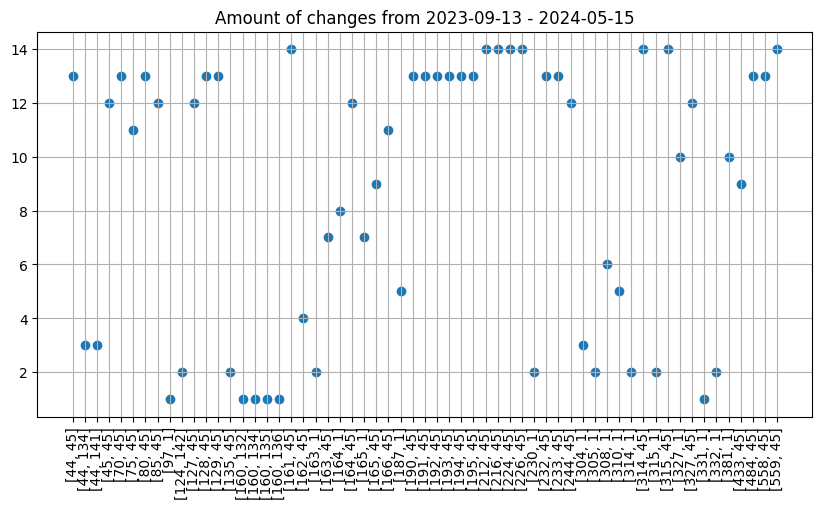

In [11]:
labels = [str(list(item)[1:]) for item in changes.keys()]
plt.figure(figsize=(10, 5))
plt.scatter(y = changes.values(), x = labels)
plt.xticks(rotation=90)
plt.title(f"Amount of changes from {min(dates)} - {max(dates)}")
plt.grid()
plt.show()


Kijkende naar alle be52 bestanden

In [12]:
df_be52 = [row for row in df_db.itertuples() if row.file_name in be52]
df_be52 = pd.DataFrame(df_be52)

In [13]:
# change df
df_pivot = df_be52.pivot(index=["linac", "file_name", "item", "part"], columns="date", values="value")
df_pivot.reset_index(inplace=True)

# the dates all the different file types been uploaded
file_dates = {name : sorted(list(set(df_be52[df_be52["file_name"] == name]["date"]))) for name in set(df_be52["file_name"])}

In [18]:
#how much every part&item changed
changes_per_file = {}

for file_name, file_date in file_dates.items():
    # grab the dates that this file has been uploaded
    df_change = df_pivot[df_pivot["file_name"] == file_name].loc[:,file_date]
    # Calculate how much difference there is between old and new
    df_changes =  df_change.iloc[:,1:].values - df_change.iloc[:,:-1].values
   
    # make a df from the changes and the information of linac, item en part
    df_changed = pd.concat([df_pivot[df_pivot["file_name"] == file_name].loc[:,["linac", "item", "part"]].reset_index(), 
               pd.DataFrame(df_changes, columns=df_change.columns[1:])], axis=1)
    df_changed[f"first_entry: {file_date[0]}"] = df_pivot.loc[:,file_date[0]]
    changes_per_file[file_name] = df_changed



In [19]:
#get the sum of the amount of changes

plotting_per_file = pd.DataFrame()
for file_name, df_changes in changes_per_file.items():
    for linac in set(df_changes["linac"]):
        # get how many times there was a diffence between col
        date_columns = df_changes.columns.difference(['date', 'linac', 'file_name', 'item', 'part', df_changes.columns[-1]])
        plotting = list((df_changes[date_columns] != 0).sum()[:-1]) 
        first_date = re.findall(r"\d{4}-\d{2}-\d{2}", df_changes.columns[-1])[0]
        # # set it in the dict
        data = {
            "Amount": plotting,
            "Date": list(date_columns[:-1]),
            "Linac": [linac] * len(plotting),
            "File name": [file_name] * len(plotting),
            "First entry": [first_date] * len(plotting)
        }
        plotting_per = pd.DataFrame(data) 
        plotting_per_file = pd.concat([plotting_per_file, plotting_per])


In [20]:
px.line(plotting_per_file, x='Date', y='Amount', color='File name', markers=True, symbol='Linac', hover_data="First entry")


In [21]:
total_df = pd.DataFrame()
for filename, df_changes in changes_per_file.items():
    if df_changes.columns[-2] != "part":

        old_data = df_changes[df_changes.columns[-1]]
        dif = df_changes[df_changes.columns[-2]]

        data = {
                "File name": [file_name] * len(df_changes),
                "Item & part": "I:"+ df_changes["item"].astype(str) + " P:"+ df_changes["part"].astype(str),
                "Difference": list(dif),
                "Old data": list(old_data),
                "New data": list(old_data - dif)
            }
        temp_df = pd.DataFrame(data) 
        total_df = pd.concat([total_df, temp_df])


In [22]:
total_df = pd.DataFrame()
ip = "I:1 P:4"
for filename, df_changes in changes_per_file.items():
    if df_changes.columns[-2] != "part":
        df_changes["Item & part"] = "I:"+ df_changes["item"].astype(str) + " P:"+ df_changes["part"].astype(str)
        dates = list(df_changes.columns)[4:-2]
        data = {
                "Linac": [df_changes["linac"][1]] * len(dates),
                "Item & part": [ip] * len(dates),
                "date": dates,
                "Difference": df_changes[df_changes["Item & part"] == ip][dates].values[0],
                "First entry": df_changes[df_changes["Item & part"] == ip].iloc[:,-2].values[0]
            }
        
        temp_df = pd.DataFrame(data) 
        total_df = pd.concat([total_df, temp_df])

De Be.... bestanden Item & parts bevat  
    gun current

In [23]:
for key, value in description.items():
    if "gun" in key:
        print(f"{value} : {key}")

item: 123, part: 133, Parameter 3 function : This item shows the servo error from the slits gun control system. The item is not used in digital accelerators fitted with a slitless flight tube and hardware gun servo.
item: 186, part: 1, Setting value : This item controls the loop gain of the hardware system. It is configured for the hardware gun servo option only.
item: 187, part: 1, Setting value : This item controls an analog reference voltage used by the hardware gun servo option.
item: 216, part: 45, Confirmed value : The value of this item is the monitored voltage of the electron gun.
item: 235, part: 45, Confirmed value : This item is not used when the digital accelerator is fitted with a slitless flight tube and hardware gun servo.
item: 327, part: 200, Process_Param_24_Part  : The servo control item for the electron gun filament current.
item: 369, part: 1, Setting value : This item controls the gun aim level for servo operation. The item is not used when the digital accelerator

Item 381 is de belangrijkste van het stel, het geeft de setting value van de gun aim current level voor dat energie niveau.

In [24]:
be5201["Part&item"] = "I:"+ be5201["item"].astype(str) + " P:"+ be5201["part"].astype(str)
be5201[be5201["Part&item"] == "I:381 P:1"]

px.line(be5201[be5201["Part&item"] == "I:381 P:1"], x="date", y ="value" )


In [25]:

col = be5201[be5201["date"] == "2024-05-15"]["value"].values - be5201[be5201["date"] == "2023-09-13"]["value"].values
temp_df = be5201[be5201["date"] == "2024-05-15"]
temp_df["dif"] = col

pI = temp_df[temp_df["dif"] != 0]["Part&item"]


C:\Users\Laris\AppData\Local\Temp\ipykernel_15548\2290091072.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
plotting = be5201[be5201["Part&item"].isin(pI)]

fig = px.line(plotting, x="date", y ="value" ,color="Part&item", title = f"Alle aangepaste items in 1 plot met de waarde van aanpassing")
fig.show()


Een mogelijke verdeling van deze part en itmes is te doen op basis van de onderdelen in de tekeningen van de machine vanuit elekta.

In [27]:
groups = pd.read_csv("data/groups_partly.tsv", sep="\t")
groups["Part&item"] = "I:" + groups["item"].astype(str) + " P:" + groups["part"].astype(str)
plotting = pd.merge(groups, be5201, on="Part&item", how="inner")
fig = px.line(plotting, x="date", y="value", color="groep", line_group="Part&item", 
              title="Alle aangepaste items gegroepeerd in 1 plot met de waarde van aanpassing", 
              hover_data="Part&item", markers=True)


fig.show()


#### Correlatie tussen de items en parts

In [28]:

# copy the data 
be5201_max_scaled = be5201[["value", "Part&item", 'date']].pivot(index='date', columns='Part&item', values='value') 

# apply normalization techniques 
for column in be5201_max_scaled.columns: 
	be5201_max_scaled[column] = be5201_max_scaled[column] / be5201_max_scaled[column].abs().max() 
	


<Axes: xlabel='Part&item', ylabel='Part&item'>

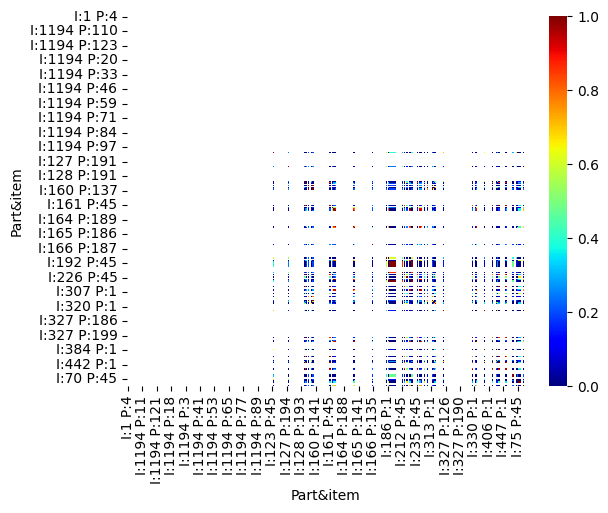

In [29]:
corr = be5201_max_scaled.corr()
sns.heatmap(corr, cmap="jet", vmin=0.0, vmax=1.0)

###### gun filament

In [30]:

high_corr_pairs = []

# Loop door de correlatiematrix
for col in corr.columns:
    for row in corr.index:
        if abs(corr.loc[row, col]) > 0.4 and row != col:
            high_corr_pairs.append((row, col, corr.loc[row, col]))

# Maak een DataFrame van de paren die we hebben gevonden
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Item 1', 'Item 2', 'Correlation'])

# Toon de paren en hun correlaties
df_381 = high_corr_df[high_corr_df["Item 1"] == "I:381 P:1"]

new_plotting = be5201_max_scaled.reset_index().melt(id_vars=["date"], var_name="Part&item", value_name="value")

In [31]:

plotting = pd.merge(groups, new_plotting, on="Part&item", how="inner")
fig = px.line(plotting, x="date", y="value", color="groep", line_group="Part&item", 
              title="Alle aangepaste items gegroepeerd in 1 plot met de waarde van aanpassing", 
              hover_data="Part&item", markers=True)



In [32]:

fig = px.line(new_plotting[new_plotting["Part&item"].isin(df_381["Item 2"])]
, x="date", y="value" ,color="Part&item",
              title="I:381 P:1 correlation items en parts", 
              hover_data="Part&item", markers=True)


fig.show()


In [33]:

new = df_381[df_381["Correlation"] > 0.5]
fig = px.line(plotting[plotting["Part&item"].isin(new["Item 2"])]
, x="date", y="value" ,color="groep", line_group="Part&item",
              title="I:381 P:1 correlation items en parts grouped", 
              hover_data="Part&item", markers=True)


fig.show()


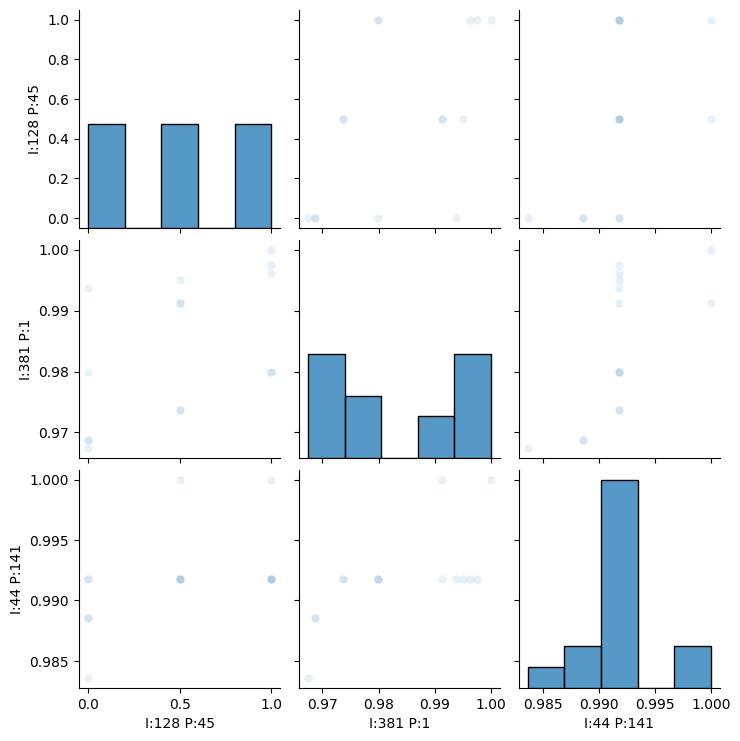

In [34]:
check = new["Item 2"].tolist()
check.append("I:381 P:1")
df_ml = plotting[plotting["Part&item"].isin(check)]
df_ml = df_ml[["value", "Part&item", 'date']].pivot(index='date', columns='Part&item', values='value') 

sns.pairplot(df_ml, plot_kws={'alpha': 0.1})

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate

In [36]:
# #apply normalization techniques 
# for column in df_ml.columns: 
# 	df_ml[column] = df_ml[column] / df_ml[column].abs().max() 

plotting = be5201[be5201["Part&item"].isin(pI)]

df_ml = plotting[["value", "Part&item", 'date']].pivot(index='date', columns='Part&item', values='value') 

y = df_ml["I:381 P:1"]
X = df_ml.drop("I:381 P:1", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
	

In [37]:
models= [
    LinearRegression,
    RandomForestRegressor,
    SVR,
    GaussianProcessRegressor,
    BayesianRidge
]

metric_scores = {}
for model in models:
    scores = cross_validate(model(), X, y, return_train_score=True)
    for key, val in scores.items():
        scores[key] = val.mean()
    metric_scores[f"{model.__name__}"] = scores
    
pd.DataFrame(metric_scores).T

,fit_time,score_time,test_score,train_score
LinearRegression,0.006824,0.003300,-369.845504,1.000000
RandomForestRegressor,0.212280,0.018733,-92.594590,0.970665
SVR,0.003570,0.002869,-345.550140,-0.005057
GaussianProcessRegressor,0.005889,0.003497,-659498.915445,1.000000
BayesianRidge,0.004628,0.002615,-369.845608,1.000000
